### IMPORTS

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import warnings

warnings.filterwarnings('ignore')

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


$\textbf{QUESTION 1}$

In [2]:
babies = pd.read_csv('babies.csv')
cord_clamped = babies['x']
not_clamped = babies['y']

0     13.8
1      8.0
2      8.4
3      8.8
4      9.6
5      9.8
6      8.2
7      8.0
8     10.3
9      8.5
10    11.5
11     8.2
12     8.9
13     9.4
14    10.3
15    12.6
Name: x, dtype: float64
9.64375


<Axes: >

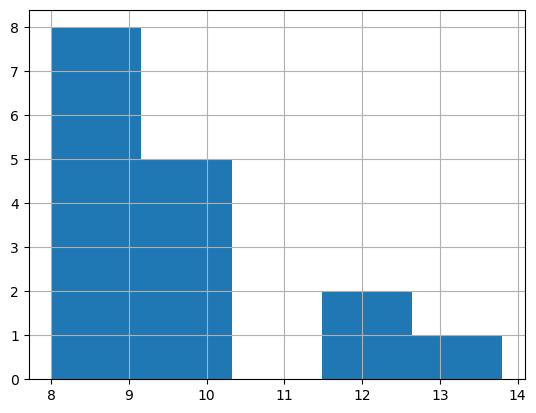

In [3]:
print(cord_clamped)
print(cord_clamped.mean())
cord_clamped.hist(bins=5)

0     10.4
1     13.1
2     11.4
3      9.0
4     11.9
5     16.2
6     14.0
7      8.2
8     13.0
9      8.8
10    14.9
11    12.2
12    11.2
13    13.9
14    13.4
15    11.9
Name: y, dtype: float64
12.09375


<Axes: >

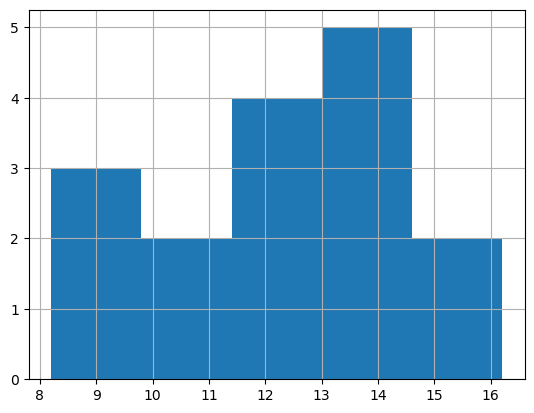

In [4]:
print(not_clamped)
print(not_clamped.mean())
not_clamped.hist(bins=5)

In [8]:

with pm.Model() as model:
    
    # Define noninformative Gamma priors
    shape_prior = 0.001
    rate_prior = 0.001
    alpha1 = pm.Gamma(name="alpha1", alpha=shape_prior, beta=rate_prior)
    beta1 = pm.Gamma(name="beta1", alpha=shape_prior, beta=rate_prior)
    alpha2 = pm.Gamma(name="alpha2", alpha=shape_prior, beta=rate_prior)
    beta2 = pm.Gamma(name="beta2", alpha=shape_prior, beta=rate_prior)
    
    # Priors for the means
    # mean1 = pm.Gamma(name='mean1', alpha=shape_prior, beta=rate_prior)
    # mean2 = pm.Gamma(name='mean2', alpha=shape_prior, beta=rate_prior)
    mean1, mean2 = alpha1 / beta1, alpha2 / beta2 

    # Likelihoods for the data
    likelihood1 = pm.Gamma(name='likelihood1', alpha=alpha1, beta=beta1, observed=cord_clamped)
    likelihood2 = pm.Gamma(name='likelihood2', alpha=alpha2, beta=beta2, observed=not_clamped)

    # Difference in means
    diff = mean1 - mean2
    diff_means = pm.Deterministic(name='diff_means', var=diff)

    # Sampling
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha1, beta1, alpha2, beta2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 162 seconds.


In [24]:
# View trace diff_means
diff_means_trace = az.summary(data=trace, var_names=['diff_means'], hdi_prob=.90)
print(f"Trace Summary for difference in means:\n{diff_means_trace}\n")

# Print trace summary
print(f"Trace Summary:\n{az.summary(data=trace, hdi_prob=.90)}\n")

# Check Credible Set
print(f"The 90% Credible Set for the difference of means:\n{diff_means_trace}")

Trace Summary for difference in means:
             mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
diff_means -2.476  0.741  -3.645   -1.258      0.011    0.008    4240.0   

            ess_tail  r_hat  
diff_means    3026.0    1.0  

Trace Summary:
              mean      sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
alpha1      34.558  12.392  14.233   52.898      0.379    0.268    1047.0   
beta1        3.585   1.294   1.513    5.569      0.040    0.028    1043.0   
alpha2      27.962  10.147  11.304   43.262      0.293    0.207    1145.0   
beta2        2.309   0.843   0.958    3.607      0.024    0.017    1143.0   
diff_means  -2.476   0.741  -3.645   -1.258      0.011    0.008    4240.0   

            ess_tail  r_hat  
alpha1        1199.0    1.0  
beta1         1151.0    1.0  
alpha2        1246.0    1.0  
beta2         1201.0    1.0  
diff_means    3026.0    1.0  

The 90% Credible Set for the difference of means:
             mean     sd  hdi_5%  hdi_95

$$
\text{The 90\% credible set doesn't contain 0.} \Rightarrow \text{The difference is statistically significant.}
$$

$\textbf{QUESTION 2}$

In [14]:
intraocular_pressure = pd.read_excel('iop2.xlsx', header=None, names=['indicator', 'cornea_thickness'])
low_iop = intraocular_pressure['indicator']
corn_thickness = intraocular_pressure['cornea_thickness']

0      1
1      1
2      1
3      0
4      1
      ..
135    0
136    0
137    0
138    0
139    0
Name: indicator, Length: 140, dtype: int64
0.24285714285714285
indicator
0    106
1     34
Name: count, dtype: int64


<Axes: >

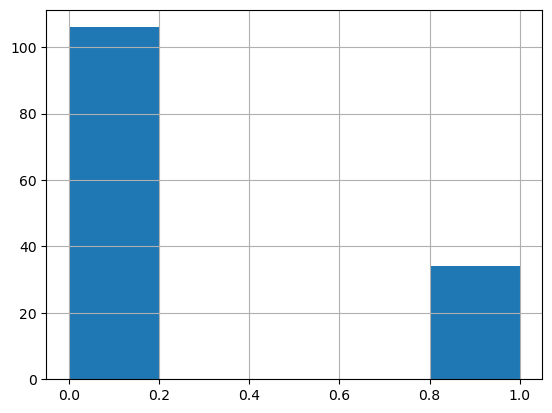

In [21]:
print(low_iop)
print(low_iop.mean())
print(low_iop.value_counts())
low_iop.hist(bins=5)

0      386
1      397
2      397
3      409
4      412
      ... 
135    561
136    565
137    565
138    569
139    590
Name: cornea_thickness, Length: 140, dtype: int64
484.65714285714284


<Axes: >

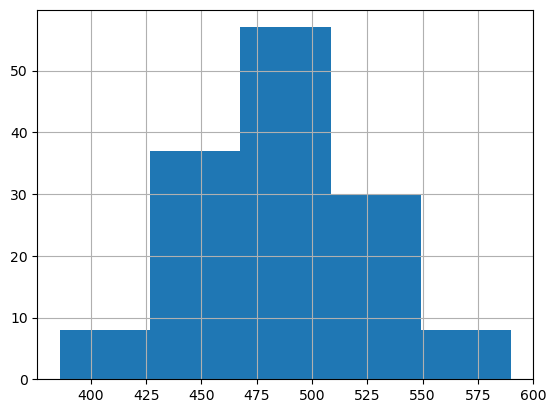

In [16]:
print(corn_thickness)
print(corn_thickness.mean())
corn_thickness.hist(bins=5)

$$
\textbf{PART A}
$$

In [ ]:
# Define the logistic function
def logistic(x, beta, alpha):
    return 1

with pm.Model() as logistic_model:
    
    # Priors for the regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0, sigma=1)

    # Expected value of outcome
    p = pm.Deterministic('p', logistic(corn_thickness, beta, alpha))

    # Likelihood (sampling distribution) of observations
    observed = pm.Bernoulli('obs', p=p, observed=Y)

    # Use the No-U-Turn Sampler
    trace = pm.sample(2000, tune=1000, cores=1)

# Summarize the trace
print(pm.summary(trace))

$$
\textbf{PART B}
$$

$$
\textbf{PART C}
$$

$\textbf{QUESTION 3}$

$$
\textbf{PART A}
$$

$$
\textbf{PART B}
$$